Analysis the results under new code

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2
import pandas as pd
from IPython.display import display


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [46]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from scenarios.simu_linear_psd import settings
from scenarios.simu_linear_sinica import settings as settingss



In [47]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [48]:
from optimization.opt import logger as logger1
logger1.handlers[0].setLevel(logging.WARNING)

In [49]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_dtype(torch.float64)

# Param and fns

## Fns

In [50]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
_err_fn = lambda x: np.nanmean(x**2)
#_err_fn = lambda x: np.nanmean(np.abs(x))

<function __main__.<lambda>(x)>

# Analysis

In [51]:

num_rep = 200;

In [232]:
nb = 1
setting = settings[f"cmpn{nb}"] # add more for 0.8
#setting = settingss[f"cmpns{nb}"] # add more for 0.8
can_Ns = setting.can_Ns
can_lams = setting.can_lams
can_Ns = [6, 8, 10, 12, 14]

c1s = [0.0, 0.2, 0.4]
Cmat = np.eye(nb) # change it depending on test1, test2, test3

array([[1.]])

In [233]:
Cmat.shape

(1, 1)

## Pre-ana

In [222]:
c1 = 0.0

0.0

In [223]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            errs.append(all_cv_errs[(seed, cur_N, cur_lam)].mse_loss)
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
# do not make n_jobs>1, it is very slow
with Parallel(n_jobs=1) as parallel:
    err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
err_ten = np.array(err_ten);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns3_0/all-valsel-metrics.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 16116.13it/s]


In [224]:
err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
err_m = np.median(np.array(err_ten), axis=0)
errs = []
for err in err_m:
    lam_min_idx = _get_min_idx(err)
    errs.append((err[lam_min_idx], lam_min_idx))
errs = np.array(errs)
N_min_idx = np.argmin(errs[:, 0]);
lam_min_idx = int(errs[N_min_idx][1]);
min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
min_opt_N, min_opt_lam

err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
(can_Ns[N_min_idx], can_lams[lam_min_idx], can_lams[lam_1se_idx])

(6, 0.4, 0.5)

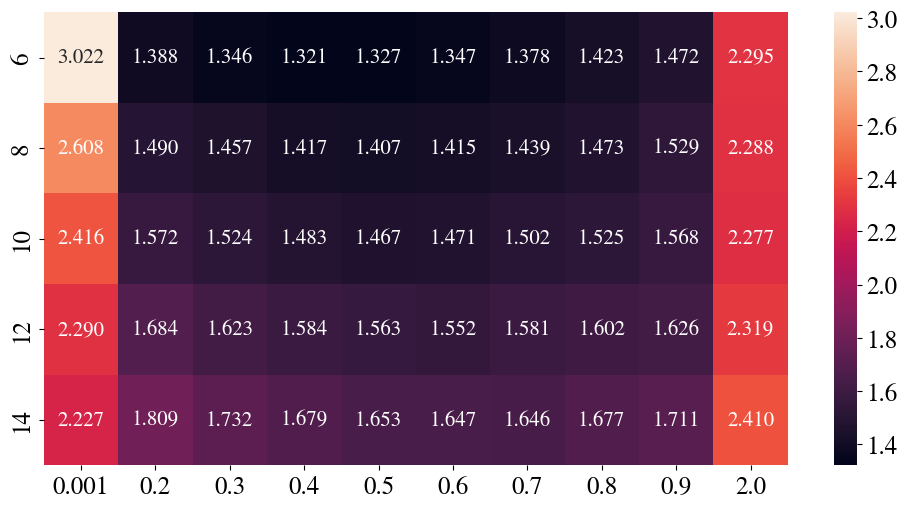

In [225]:
plt.figure(figsize=[12, 6])
sns.heatmap(err_m, annot=err_m, fmt=".3f")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

## Step 2 (only need once)

### Fix N and adaptive lam

In [182]:
# then given N, find opt lam
def _run_fn_fixN(seed, optN, all_cv_errs):
    errs = []
    for cur_lam in can_lams:
        errs.append(all_cv_errs[(seed, optN, cur_lam)].mse_loss)
    min_idx = _get_min_idx(errs);
    return (seed, optN, can_lams[min_idx], errs[min_idx])

optN = 6
opt_lamss = dict()
for c1 in tqdm(c1s):
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    opt_lams = [_run_fn_fixN(seed, optN, all_cv_errs) for seed in range(num_seed)]
    opt_lamss[c1] = opt_lams

  0%|                                                                                      | 0/4 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_0/all-valsel-metrics.pkl


 50%|███████████████████████████████████████                                       | 2/4 [00:00<00:00,  4.73it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_100/all-valsel-metrics.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_200/all-valsel-metrics.pkl


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_400/all-valsel-metrics.pkl


In [183]:
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    opt_lamNs =  opt_lamss[c1]
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        _test_fn = res1.hypo_test
        with Parallel(n_jobs=1) as parallel:
            res = parallel(delayed(_test_fn)(Cmat=Cmat, is_simpler=False,
                                             hypo_params={"svdinv_eps_Q": rtols[0], "svdinv_eps_Psi": rtols[1]}) 
                           for rtols in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixN_ress.pkl", ress, is_force=1)

c1: 0: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 18.11it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_0/opt_lamNsfixN_ress.pkl


c1: 100: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.26it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_100/opt_lamNsfixN_ress.pkl


c1: 200: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.50it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_200/opt_lamNsfixN_ress.pkl


c1: 400: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.02it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns2b_400/opt_lamNsfixN_ress.pkl


### Adaptive N and lam

In [195]:
def _run_fn(seed, all_cv_errs):
    errs_N = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            errs.append(all_cv_errs[(seed, cur_N, cur_lam)].mse_loss)
        min_idx = _get_min_idx(errs);
        errs_N.append((seed, cur_N, can_lams[min_idx], errs[min_idx]))
    errs_N_sorted = sorted(errs_N, key=lambda x:x[-1]);
    return errs_N_sorted[0]

opt_lamNss = dict()
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        opt_lamNs = parallel(delayed(_run_fn)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    opt_lamNss[c1] = opt_lamNs

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_0/all-valsel-metrics.pkl


c1: 0.0: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4534.95it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_100/all-valsel-metrics.pkl



c1: 0.1: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4454.49it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_200/all-valsel-metrics.pkl


c1: 0.2: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4408.79it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_400/all-valsel-metrics.pkl


c1: 0.4: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4378.42it/s]


In [196]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    opt_lamNs =  opt_lamNss[c1]
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        _test_fn = res1.hypo_test
        with Parallel(n_jobs=1) as parallel:
            res = parallel(delayed(_test_fn)(Cmat=Cmat, is_simpler=False,
                                             hypo_params={"svdinv_eps_Q": rtols[0], "svdinv_eps_Psi": rtols[1]}) 
                           for rtols in all_coms)
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNs_ress.pkl", ress, is_force=1)


c1: 0: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.70it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_0/opt_lamNs_ress.pkl


c1: 100: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.74it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_100/opt_lamNs_ress.pkl


c1: 200: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.41it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_200/opt_lamNs_ress.pkl


c1: 400: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.29it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpns1b_400/opt_lamNs_ress.pkl


In [40]:
for k, v in opt_lamNss.items():
    v = np.array(v)[:, 1:3]
    combos, cts = np.unique(v, axis=0, return_counts=1)
    tres = np.concatenate([combos, cts.reshape(-1, 1)], axis=1)
    display(pd.DataFrame(tres));

,0,1,2
0,12.0,0.50,3.0
1,12.0,0.60,7.0
2,12.0,0.65,5.0
3,12.0,0.70,6.0
4,12.0,0.80,7.0
5,12.0,0.90,7.0
6,12.0,1.00,23.0
7,14.0,0.40,1.0
8,14.0,0.50,7.0
9,14.0,0.60,7.0


,0,1,2
0,12.0,0.50,2.0
1,12.0,0.60,2.0
2,12.0,0.65,6.0
3,12.0,0.70,6.0
4,12.0,0.80,4.0
5,12.0,0.90,12.0
6,12.0,1.00,21.0
7,14.0,0.40,1.0
8,14.0,0.50,3.0
9,14.0,0.60,11.0


,0,1,2
0,12.0,0.50,4.0
1,12.0,0.60,2.0
2,12.0,0.65,3.0
3,12.0,0.70,3.0
4,12.0,0.80,5.0
5,12.0,0.90,10.0
6,12.0,1.00,19.0
7,14.0,0.40,1.0
8,14.0,0.50,2.0
9,14.0,0.60,10.0


### Fixed N and fixed lam

In [234]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            #errs.append(all_cv_errs[(seed, cur_N, cur_lam)].BIC)
            errs.append(all_cv_errs[(seed, cur_N, cur_lam)].mse_loss)
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
opt_lamNs_fix = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                 for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    err_ten = np.array(err_ten);
    
    err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
    err_m = np.median(np.array(err_ten), axis=0)
    errs = []
    for err in err_m:
        lam_min_idx = _get_min_idx(err)
        errs.append((err[lam_min_idx], lam_min_idx))
    errs = np.array(errs)
    N_min_idx = np.argmin(errs[:, 0]);
    lam_min_idx = int(errs[N_min_idx][1]);
    min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
    
    err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
    lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
    print(can_Ns[N_min_idx], can_lams[lam_min_idx], can_lams[lam_1se_idx])
    opt_lamNs_fix[c1] = (can_Ns[N_min_idx],  can_lams[lam_min_idx])

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_0/all-valsel-metrics.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18161.48it/s]

6 0.8 1.0
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_200/all-valsel-metrics.pkl



c1: 0.2: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18311.34it/s]


8 1.0 1.2
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_400/all-valsel-metrics.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 17900.66it/s]

8 1.1 1.2


In [235]:
opt_lamNs_fix

{0.0: (6, 0.8), 0.2: (8, 1.0), 0.4: (8, 1.1)}

In [236]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    cur_N, cur_lam = opt_lamNs_fix[c1]
    def _run_fn_test(cur_seed):
        from optimization.opt import logger as logger1
        logger1.handlers[0].setLevel(logging.WARNING)
        torch.set_default_dtype(torch.float64)
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res1.basis_mat = torch.tensor(res1.obt_bsp(np.linspace(0, 1, setting.data_gen_params.npts), 
                                      res1.bsp_params.N, res1.bsp_params.basis_ord)).to(torch.get_default_dtype());
        res = []
        for rtols in all_coms:
            re = res1.hypo_test(Cmat=Cmat, ts=None, is_simpler=False, hypo_params={"svdinv_eps_Q": rtols[0], "svdinv_eps_Psi": rtols[1]}) 
            res.append(re)
    
        return res 
    with Parallel(n_jobs=10) as parallel:
        ress = parallel(delayed(_run_fn_test)(cur_seed) for cur_seed in tqdm(range(num_rep), desc=f"c1: {c1*1000:.0f}", total=num_rep))
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixNlam_ress.pkl", ress, is_force=1)

c1: 0: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 652.08it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_0/opt_lamNsfixNlam_ress.pkl


c1: 200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 592.14it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_200/opt_lamNsfixNlam_ress.pkl


c1: 400: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 628.33it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_400/opt_lamNsfixNlam_ress.pkl


## Find Q and Psi rtol

In [237]:
ress_dict = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_setting{setting.setting}_{c1*1000:.0f}"
    ress = load_pkl(cur_save_dir/f"opt_lamNsfixNlam_ress.pkl");
    #ress = load_pkl(cur_save_dir/f"opt_lamNsfixN_ress.pkl");
    #ress = load_pkl(cur_save_dir/f"opt_lamNs_ress.pkl");
    #ress = load_pkl(cur_save_dir/f"opt_lamNsfixN1se_c1_{c1*1000:.0f}_ress.pkl");
    ress_dict[c1] = ress

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_0/opt_lamNsfixNlam_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_200/opt_lamNsfixNlam_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_settingcmpn1_400/opt_lamNsfixNlam_ress.pkl


In [238]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [239]:
import pandas as pd
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]

all_coms = np.array(list(itertools.product(cans, cans)));
all_coms = [(can, can) for can in cans]
kpidxs = []

df = []
for c1 in c1s:
    ress = ress_dict[c1]
    pvals = np.array([[re["pval"] for re in res] for res in ress]);
    T_vss = np.array([[re["T_v"] for re in res] for res in ress]);
    
    kpidxss = [outlier_det(T_vss[:, can_ix], 0.00) for can_ix in range(T_vss.shape[1])];
    if True:
        vec_pv = np.array([np.mean(pvals[:, can_ix][kpidxss[can_ix]]<0.05) for can_ix in range(len(cans))])
    else:
        vec_pv = np.array([np.mean(pvals[:, can_ix]<0.05) for can_ix in range(len(cans))])
    #vec_pv = np.mean(pvals<0.05, axis=0)
    df.append(vec_pv[:, np.newaxis])
df.append(all_coms) 
df = np.hstack(df)
df = pd.DataFrame(df) 
df.columns = c1s+["Q", "Psi"]
df

,0.0,0.2,0.4,Q,Psi
0,0.055,0.180,0.62,1.000000e-05,1.000000e-05
1,0.055,0.180,0.62,3.000000e-06,3.000000e-06
2,0.055,0.180,0.62,1.000000e-06,1.000000e-06
3,0.055,0.180,0.62,3.000000e-07,3.000000e-07
4,0.055,0.180,0.62,1.000000e-07,1.000000e-07
5,0.055,0.180,0.62,3.000000e-08,3.000000e-08
6,0.055,0.180,0.62,1.000000e-08,1.000000e-08
7,0.055,0.180,0.62,3.000000e-09,3.000000e-09
8,0.055,0.180,0.62,1.000000e-09,1.000000e-09
9,0.055,0.180,0.62,3.000000e-10,3.000000e-10


In [208]:
c1 = 0.0
ress = ress_dict[c1]
pvals = np.array([[re["pval"] for re in res] for res in ress]);
T_vss = np.array([[re["T_v"] for re in res] for res in ress]);
T_vss.mean(axis=0)

array([1125.18565091,   16.56158501,   16.1649357 ,   16.3027755 ,
         15.25156412,   14.72733094,   14.68217806,   14.65961951,
         14.6614984 ,   14.66102065,   14.66102065])

In [133]:
c1 = 0.0
cur_save_dir = RES_ROOT/f"simu_settingnm1b_{0.4*1000:.0f}"
cur_N = 14
cur_lam = 1.2
def _run_fn_test(cur_seed):
        from optimization.opt import logger as logger1
        logger1.handlers[0].setLevel(logging.WARNING)
        torch.set_default_dtype(torch.float64)
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        #res1.basis_mat = torch.tensor(res1.obt_bsp(np.linspace(0, 1, setting.data_gen_params.npts), 
        #                              res1.bsp_params.N, res1.bsp_params.basis_ord)).to(torch.get_default_dtype());
        #res = res1.hypo_test(Cmat=Cmat, ts=None, is_simpler=False, 
        #                     hypo_params={"svdinv_eps_Q": 1e-7, "svdinv_eps_Psi": 1e-7}) 
    
        return res1 

In [134]:
ress = []
for rep_ix in range(200):
    res = _run_fn_test(rep_ix)
    ress.append(res.keep_idxs)

In [135]:
np.sum(np.array(ress)[:, -1]!=67)

2